Auteur: Michaël Leroy

 Graph depuis gdf Nodes et edges
        - heatmap of of passthrough communes paths counts 

        .....

In [1]:
class CFG:
    data_path = './osm_datas/'
    data_path_mappers = './datas'
    path_paths = './tourism_paths'
    score_path = './tourism_scores'
    folium_path = './tourism_viz'
    area_name = 'france'

    

    

import os
os.environ['USE_PYGEOS'] = '0'

import joblib
# joblib.dump(
#     CFG, 
#     os.path.join(
#         CFG.score_path,
#         'CFG_for_tourism_score.pkl'
#     ) 
# )   


# %load_ext autoreload
# %autoreload


# %aimport OSM_helper_functions
# %aimport OCM_helper_functions

import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
# from OSM_helper_functions import *
# from OCM_helper_functions import *


ox.settings.log_console=True
ox.settings.use_cache=True
''' To retrieve http data from OSMnx and cache them locally
    before building graph. Raise and exception if requests
    are all done. intercept then set to False and retry.'''
# ox.settings.cache_only_mode=True 



C:\Users\demo\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


' To retrieve http data from OSMnx and cache them locally\n    before building graph. Raise and exception if requests\n    are all done. intercept then set to False and retry.'

* 1 retrieve start cities and start_nodes from directory

In [2]:
# Mappers to link osmids to commune names


# Dict to map osmid  -> communes names
Osmid2Name = joblib.load(
    os.path.join(CFG.data_path_mappers,f'[{CFG.area_name}]mapper_osmid_to_libgeo.pkl')
)

# Dict to map communes names  -> osmid 
Name2Osmid = joblib.load(
    os.path.join(CFG.data_path_mappers,f'[{CFG.area_name}]mapper_libgeo_to_osmid.pkl')
)

In [3]:
for _, _, files in os.walk(CFG.path_paths):
    start_cities = [ file.split('_')[1][1:-1] for file in files if file.startswith('f')]
# print(f'{start_cities=}')

# start_cities to start_nodes
start_nodes = [ Name2Osmid[str.upper(name)] for name in start_cities]

for name, osmid in zip(start_cities, start_nodes):
    print(f'{name}: {osmid}')

AIX-EN-PROVENCE: 70279
AMIENS: 114347
ANGERS: 178351
AVIGNON: 102478
BESANÇON: 103599
BORDEAUX: 105270
BREST: 1076124
CAEN: 149197
CLERMONT-FERRAND: 110866
DIJON: 74090
DUNKERQUE: 139610
GRENOBLE: 80348
LA ROCHELLE: 1215878
LE HAVRE: 104492
LE MANS: 107435
LILLE: 58404
LIMOGES: 114172
LYON: 120965
MARSEILLE: 76469
METZ: 450381
MONTPELLIER: 28722
MULHOUSE: 38246
NANCY: 52399
NANTES: 59874
NICE: 170100
NÎMES: 378685
ORLÉANS: 147559
PARIS: 7444
PAU: 162431
PERPIGNAN: 18000
POITIERS: 132348
REIMS: 36458
RENNES: 54517
ROUEN: 75628
SAINT-ÉTIENNE: 117905
STRASBOURG: 71033
TOULON: 35280
TOULOUSE: 35738
TOURS: 76306


* 2 Load communes scores from directory

In [4]:
scores_df = joblib.load(
    os.path.join(
        CFG.score_path,
        'Scores_cuts.pkl'
    ))

In [5]:
scores_df.replace(0,np.nan).dropna(how='all').replace(np.nan,0).info()

<class 'pandas.core.frame.DataFrame'>
Index: 21493 entries, 153920 to 133323
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (4.0, 165.0]      21493 non-null  float64
 1   (165.0, 325.0]    21493 non-null  float64
 2   (325.0, 485.0]    21493 non-null  float64
 3   (485.0, 644.0]    21493 non-null  float64
 4   (644.0, 804.0]    21493 non-null  float64
 5   (804.0, 964.0]    21493 non-null  float64
 6   (964.0, 1124.0]   21493 non-null  float64
 7   (1124.0, 1284.0]  21493 non-null  float64
 8   (1284.0, 1443.0]  21493 non-null  float64
 9   (1443.0, 1603.0]  21493 non-null  float64
 10  total_count       21493 non-null  float64
dtypes: float64(11)
memory usage: 2.0+ MB


* 3 Load Communes graph

In [6]:
Nodes = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes_communes.pkl'))

# Edges = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gedges_communes_C22.pkl'))

In [7]:
Nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34466 entries, 2531584 to 2741108
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   y         34466 non-null  float64 
 1   x         34466 non-null  float64 
 2   codgeo    34466 non-null  object  
 3   area      34466 non-null  object  
 4   sleeping  15412 non-null  float64 
 5   visit     17923 non-null  float64 
 6   fooding   6616 non-null   float64 
 7   working   6950 non-null   float64 
 8   vehicule  4166 non-null   float64 
 9   geometry  34466 non-null  geometry
dtypes: float64(7), geometry(1), object(2)
memory usage: 3.9+ MB


In [8]:
# Edges = Edges.drop(['src_trgt'], axis=1)
# Edges = Edges.reset_index()

# Edges['u'] = Edges['u'].astype(str)
# Edges['v'] = Edges['v'].astype(str)
# Edges['key'] = Edges['key'].astype(str)

# Edges = Edges.set_index(['u','v','key'])
# PATHS = Edges.pop('path')
# # Edges.info()

In [9]:
nodes2codgeo = dict(zip(Nodes.index, Nodes['codgeo']))

In [10]:
display(Nodes.head(2))#,Edges.head(2))

,y,x,codgeo,area,sleeping,visit,fooding,working,vehicule,geometry
osmid,,,,,,,,,,
2531584,43.461438,-0.819766,64312,POLYGON ((-0.832953105776137 43.44755970632465...,2.0,NaN,NaN,NaN,NaN,POINT (-0.81977 43.46144)
279376,47.730421,0.777490,41255,POLYGON ((0.7426134063245691 47.72901158483156...,NaN,1.0,NaN,NaN,NaN,POINT (0.77749 47.73042)


In [11]:
# G_communes = ox.graph_from_gdfs(Nodes, Edges)

* 4 Create data_scores from Nodes and scores_df

In [12]:
import numpy as np

data_scores = Nodes.loc[scores_df.index,['y','x']]


In [13]:
data_scores['total'] = scores_df.total_count.astype(int)

data_scores = data_scores.replace(0, np.nan).dropna()

display(data_scores.sample(5))
print(data_scores.shape[0])
data_scores.total.describe().T

,y,x,total
osmid,,,
2617578,44.808163,2.960874,16.0
49567,45.077401,5.178130,162.0
2242114,48.600243,0.489122,607.0
28727,43.614078,3.810165,1.0
153058,49.924189,3.170577,95.0


21493


count    21493.000000
mean       441.785000
std        757.781498
min          1.000000
25%         20.000000
50%        111.000000
75%        544.000000
max       8899.000000
Name: total, dtype: float64

<AxesSubplot: ylabel='Frequency'>

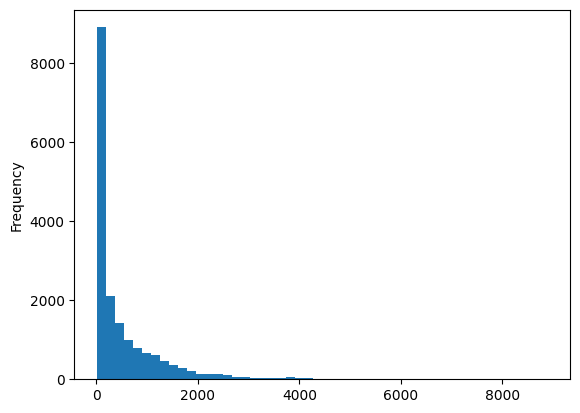

In [29]:
data_scores.total.plot(kind='hist',bins=50)

* 5 Plot folium map with:
    - markers at start cities
    - heatmap of counts for each commune

In [33]:
# Plot folium heatmap with:
# layer 1 :  communes area * counts
# layer 2 :  goal_cities * poi_counts
# layer 3 :  start_cities markers, 

import folium
from folium.plugins import HeatMap
import branca.colormap as branca_folium_cm

c_min, c_max = 0.0, 1.0
colormap = branca_folium_cm.linear.Oranges_09.scale(c_min, c_max)
# colormap = branca_folium_cm.LinearColormap(
#     colors=['blue','red'], 
#     # index=[-200,0],
#     vmin=c_min,
#     vmax=c_max)

gradient_dict = {}
for ind_val, c in zip(colormap.index, colormap.colors):
    # Create gradient dictionary for heatmap on the fly
    string = tuple(254 * np.array(c[0:3]))
    gradient_dict[ind_val] = f'rgb{string}'
display(colormap)    
display(gradient_dict)

attr = (
    '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    'contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>'
)
tiles = 'http://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'

attr, tiles = None, 'OpenStreetMap'

m = folium.Map(location= [48.8, 2.3],
                    width='100%', height='100%', left='00%', top='0%', 
                    position='relative', 
                    tiles= tiles, #OpenStreetMap',     #OpenStreetMap', Stamen
                    attr=attr,    #  None   Terrain, Toner, and Watercolor
                    min_zoom=4, max_zoom=20, zoom_start=6, 
                    min_lat= 41, max_lat=52, min_lon=- 4, max_lon=10, 
                    max_bounds=True, 
                    crs='EPSG3857', 
                    control_scale=True, prefer_canvas=False, 
                    no_touch=False, disable_3d=True, 
                    png_enabled=False, zoom_control=True)

HeatMap(
    data_scores.values, 
    name='passage', 
    min_opacity=0.35, 
    # max_zoom=18, 
    radius=12,
    blur=2, 
    gradient = gradient_dict,
    # overlay=True, 
    # control=True, 
    # show=True
).add_to(m)

for id in start_nodes:
    folium.Marker([Nodes.loc[id,'y'],Nodes.loc[id,'x']]).add_to(m)

display(m)
m.save(os.path.join(CFG.folium_path, f'[{CFG.area_name}]tourism_path_communes_rank_map.html'))
del(m)

{0.0: 'rgb(254.0, 244.03921568627453, 234.078431372549)',
 0.125: 'rgb(253.00392156862745, 229.09803921568627, 205.1921568627451)',
 0.25: 'rgb(252.0078431372549, 207.1843137254902, 161.36470588235292)',
 0.375: 'rgb(252.0078431372549, 173.31764705882352, 106.58039215686274)',
 0.5: 'rgb(252.0078431372549, 140.44705882352943, 59.76470588235294)',
 0.625: 'rgb(240.05490196078432, 104.58823529411764, 18.92549019607843)',
 0.75: 'rgb(216.14901960784314, 71.71764705882353, 0.996078431372549)',
 0.875: 'rgb(165.34901960784313, 53.78823529411765, 2.988235294117647)',
 1.0: 'rgb(126.50196078431372, 38.847058823529416, 3.984313725490196)'}

--------------------------

# Unsupervised labelling

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

df = Nodes[['sleeping','visit','working','fooding','vehicule'	]].fillna(0)

scaler = StandardScaler(with_mean=False, with_std=True)
df_scaled = scaler.fit_transform(df) 


dbscan = DBSCAN(
    eps=0.1,
    min_samples=10, 
    metric='euclidean', 
    metric_params=None, 
    algorithm='auto', 
    leaf_size=10, 
    p=2.5, 
    n_jobs=-1).fit(df_scaled)

print(f'{len(set(dbscan.labels_))=}')
pd.DataFrame(
    np.transpose(
        np.unique(
            dbscan.labels_, 
            return_counts=True
        )
    ), 
    columns=['label', 'count']
).set_index('label').T



len(set(dbscan.labels_))=21


label,-1,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
count,4175,24745,2579,1223,207,785,165,264,32,117,...,14,61,28,12,6,10,3,11,11,10


In [17]:
Nodes['labels'] = dbscan.labels_
Nodes['labels'] = Nodes['labels'].replace(-1,  np.nan).replace(0, np.nan)
Nodes['labels'].value_counts()

1.0     2579
2.0     1223
4.0      785
6.0      264
3.0      207
5.0      165
8.0      117
11.0      61
7.0       32
12.0      28
10.0      14
13.0      12
17.0      11
18.0      11
15.0      10
19.0      10
9.0        8
14.0       6
16.0       3
Name: labels, dtype: int64

In [18]:
# display(Nodes.shape[0])
# pers = Nodes['labels'].dropna()
# display(pers.shape[0])
# personalisation = dict(zip(pers.index, pers))

# + page_rank function call

-----------------------------------

In [19]:
undirected_graph = ox.utils_graph.get_undirected(
                            Graph
                    )

NameError: name 'Graph' is not defined

In [ ]:
from networkx.algorithms import node_classification

node_classification.harmonic_function(
    undirected_graph,
     max_iter=30, 
     label_name='label'    
)